In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob  # used to return all file paths that match a specific pattern


#  **IMAGE PREPROCESS**

In [2]:
images_path = '../input/flickr8k-sau/Flickr_Data/Images/'
images = glob(images_path+'*.jpg') # reading path of images following .jpg pattern
len(images)

8091

In [3]:
images[:5]

['../input/flickr8k-sau/Flickr_Data/Images/3226254560_2f8ac147ea.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/214543992_ce6c0d9f9b.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/2366643786_9c9a830db8.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/3368819708_0bfa0808f8.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/2190227737_6e0bde2623.jpg']

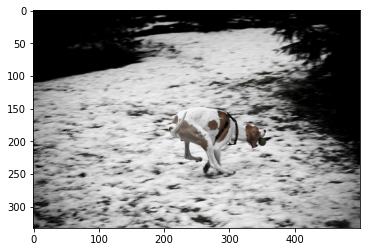

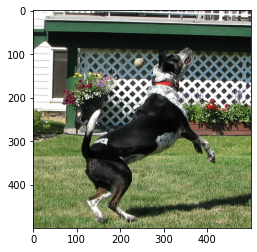

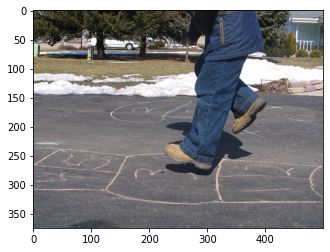

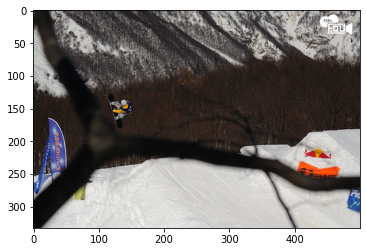

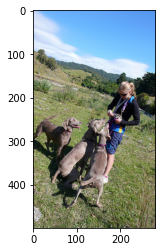

In [4]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [5]:
from keras.applications import resnet

incept_model = resnet.ResNet50(include_top=True) # ResNet50 model is imported
                # include_top=True means a fully-connected layer will be added at the end of the model
          # input to resnet is (224,224,3)

2023-01-14 17:05:32.162160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 17:05:32.163193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 17:05:32.298950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 17:05:32.299960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 17:05:32.300788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [6]:
incept_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [7]:
# from above model we can observe that the second last layer i.e avg_pool layer have only 2048 parameter
# after average pooling it(in previous layer it was 2048 feature map of 7*7 image)
# And 2048 parameters are connected to fully connected layer of 1000 neurons 



from keras.models import Model #Model groups layers into an object with training and inference features
last = incept_model.layers[-2].output   # removed the dense layer so that we can get vector of 2048 size
                               # i.e our output will we second last layer
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
 incept_model.input # our input layer

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [9]:
last

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [10]:
images_features = {} # empty Dictionary in which we will add key as name of that image and value will be output from resnet model(2048 vector)
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # because cv2 read image in BGR format but we want RGB format input
    img = cv2.resize(img, (224,224)) #reshape() does not changes the original array but only returns the changed array
    
    img = img.reshape(1,224,224,3) #the resize() method returns nothing and directly changes the original array
    pred = modele.predict(img).reshape(2048,) # so that our output contains 2048 1-D vector size
        
    img_name = i.split('/')[-1] # remove path name from image name
    
    images_features[img_name] = pred # img_name is our key for image_feature dictionary and its value if our 2048 size vector
    
    count += 1
    
    if count > 1500:
        break
        
    elif count % 100 == 0:
        print(count)

2023-01-14 17:05:37.950705: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-14 17:05:40.052502: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [11]:
images[0].split('/')[-1]

'3226254560_2f8ac147ea.jpg'

In [12]:
len(images_features)

1501

# **TEXT PREPROCESS**

In [13]:
caption_path = '../input/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'

In [14]:
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')


In [15]:
captions[0] #contains name of image and caption associated with it

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [16]:
len(captions)

40461

In [17]:
captions[0].split('\t')[0] # extracting name of image associated with it

'1000268201_693b08cb0e.jpg#0'

In [18]:
captions[0].split('\t')[0][:-2]

'1000268201_693b08cb0e.jpg'

In [19]:
captions[0].split('\t')[1] # extracting caption of image associated with it

'A child in a pink dress is climbing up a set of stairs in an entry way .'

In [20]:
captions_dict = {} # dictionary with img_name as key and caption as its value
for i in captions:
    try:
        img_name = i.split('\t')[0][:-2] 
        caption = i.split('\t')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]
                
            else:
                captions_dict[img_name].append(caption) # if image_name is already present in caption_dict then 
                                                        # we have to only add its caption
            
    except:
        pass

In [21]:
captions_dict

{'1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a girl with pigtails sitting in front of a rainbow painting .',
  'Young girl with pigtails painting outside in the grass .'],
 '102351840_323e3de834.jpg': ['A man drilling a hole in the ice .',
  'A man is drilling through the frozen ice of a pond .',
  'A person in the snow drilling a hole in the ice .',
  'A person standing on a frozen lake .',
  'Two men are ice fishing .'],
 '1024138940_f1fefbdce1.jpg': ['Two different breeds of brown and white dogs play on the beach .',
  'Two dogs are making a turn on a soft sand beach .',
  'Two dogs playing in the sand at the beach .',
  'Two dogs playing together on a beach .',
  'Two large tan dogs play along a sandy beach .'],
 '10320

In [22]:
len(captions_dict)

1501

# **VISUALIZING IMAGE WITH CAPTION**

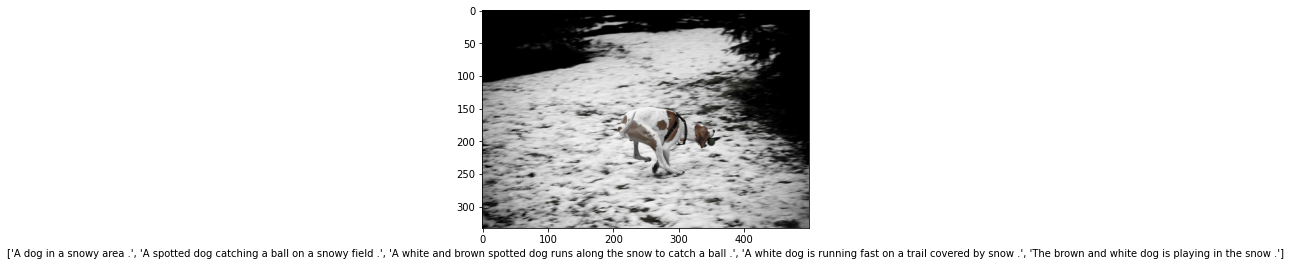

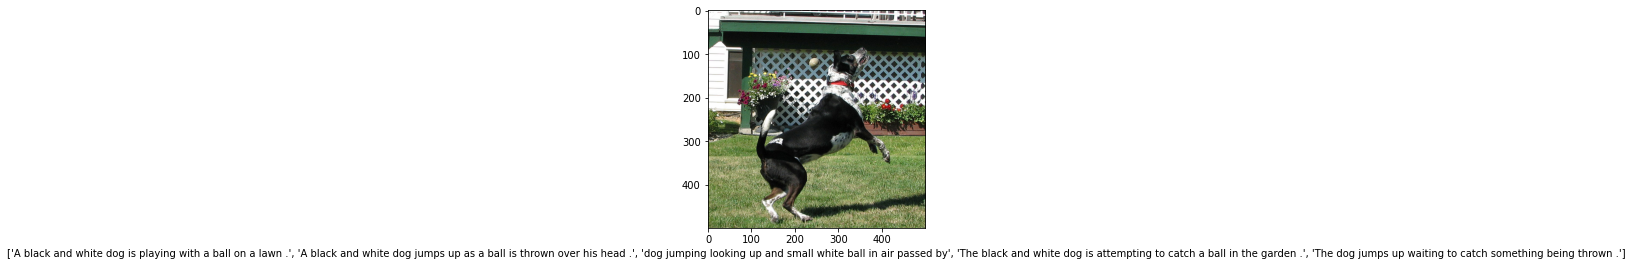

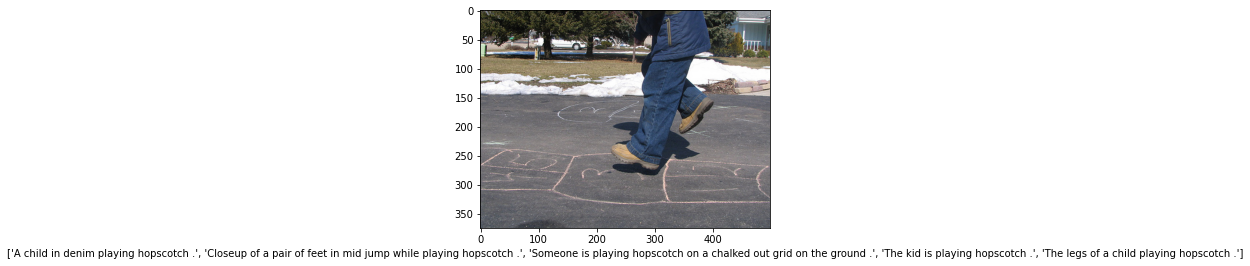

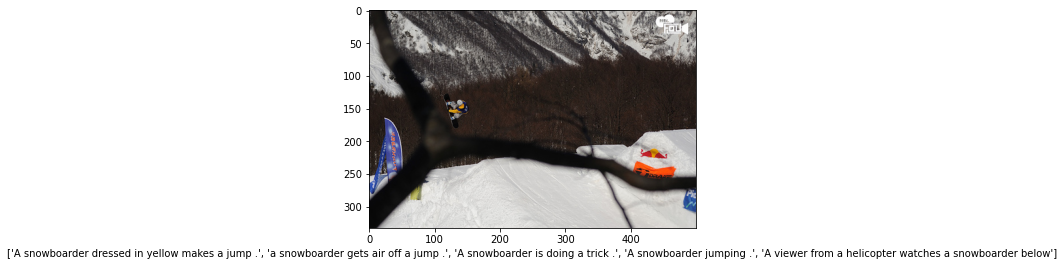

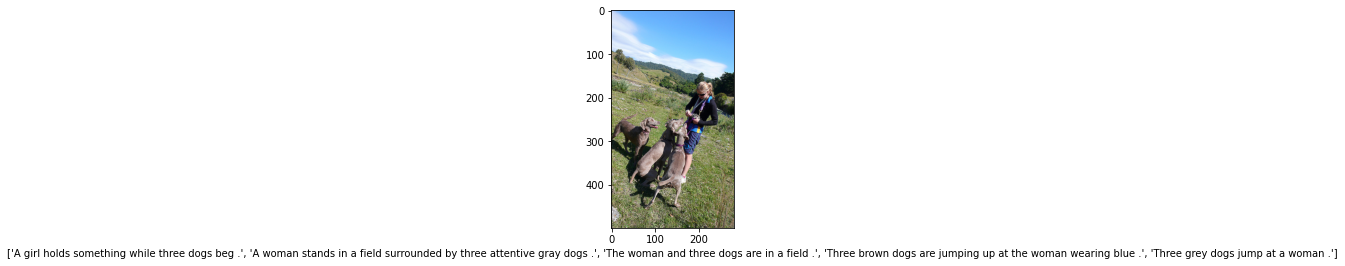

In [23]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img_name = images[i]
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)

In [24]:
def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq' # adding start of sequence and end of sequence to each captions
    return modified

In [25]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv) # adding modified caption to our captions_dict dictionary

In [26]:
captions_dict

{'1002674143_1b742ab4b8.jpg': ['startofseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . endofseq',
  'startofseq a little girl is sitting in front of a large painted rainbow . endofseq',
  'startofseq a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . endofseq',
  'startofseq there is a girl with pigtails sitting in front of a rainbow painting . endofseq',
  'startofseq young girl with pigtails painting outside in the grass . endofseq'],
 '102351840_323e3de834.jpg': ['startofseq a man drilling a hole in the ice . endofseq',
  'startofseq a man is drilling through the frozen ice of a pond . endofseq',
  'startofseq a person in the snow drilling a hole in the ice . endofseq',
  'startofseq a person standing on a frozen lake . endofseq',
  'startofseq two men are ice fishing . endofseq'],
 '1024138940_f1fefbdce1.jpg': ['startofseq two different breeds of brown and white dogs play on the beach 

# **CREATING VOCABULARY**

In [27]:
count_words = {}# numbering the words
count=1
for k,v in captions_dict.items():
    for vv in v:
        for word in vv.split():
            if word not in count_words:
                count_words[word] = count
                count+=1

           

In [28]:
len(count_words)

4077

In [29]:
count_words # but our model will only understand integer not string so we need to convert it into integer
           # and we provided it numbering according to their appearence

{'startofseq': 1,
 'a': 2,
 'little': 3,
 'girl': 4,
 'covered': 5,
 'in': 6,
 'paint': 7,
 'sits': 8,
 'front': 9,
 'of': 10,
 'painted': 11,
 'rainbow': 12,
 'with': 13,
 'her': 14,
 'hands': 15,
 'bowl': 16,
 '.': 17,
 'endofseq': 18,
 'is': 19,
 'sitting': 20,
 'large': 21,
 'small': 22,
 'the': 23,
 'grass': 24,
 'plays': 25,
 'fingerpaints': 26,
 'white': 27,
 'canvas': 28,
 'on': 29,
 'it': 30,
 'there': 31,
 'pigtails': 32,
 'painting': 33,
 'young': 34,
 'outside': 35,
 'man': 36,
 'drilling': 37,
 'hole': 38,
 'ice': 39,
 'through': 40,
 'frozen': 41,
 'pond': 42,
 'person': 43,
 'snow': 44,
 'standing': 45,
 'lake': 46,
 'two': 47,
 'men': 48,
 'are': 49,
 'fishing': 50,
 'different': 51,
 'breeds': 52,
 'brown': 53,
 'and': 54,
 'dogs': 55,
 'play': 56,
 'beach': 57,
 'making': 58,
 'turn': 59,
 'soft': 60,
 'sand': 61,
 'playing': 62,
 'at': 63,
 'together': 64,
 'tan': 65,
 'along': 66,
 'sandy': 67,
 'tent': 68,
 'being': 69,
 'set': 70,
 'up': 71,
 'about': 72,
 'to': 7

In [30]:

for k, v in captions_dict.items():
    for vv in v:
        encoded = []
        for word in vv.split():  
                encoded.append(count_words[word])


        captions_dict[k][v.index(vv)] = encoded

In [31]:
captions_dict#this dictionary will store image names and number associated with their corresponding captions word 

{'1002674143_1b742ab4b8.jpg': [[1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   6,
   9,
   10,
   2,
   11,
   12,
   13,
   14,
   15,
   6,
   2,
   16,
   17,
   18],
  [1, 2, 3, 4, 19, 20, 6, 9, 10, 2, 21, 11, 12, 17, 18],
  [1,
   2,
   22,
   4,
   6,
   23,
   24,
   25,
   13,
   26,
   6,
   9,
   10,
   2,
   27,
   28,
   13,
   2,
   12,
   29,
   30,
   17,
   18],
  [1, 31, 19, 2, 4, 13, 32, 20, 6, 9, 10, 2, 12, 33, 17, 18],
  [1, 34, 4, 13, 32, 33, 35, 6, 23, 24, 17, 18]],
 '102351840_323e3de834.jpg': [[1, 2, 36, 37, 2, 38, 6, 23, 39, 17, 18],
  [1, 2, 36, 19, 37, 40, 23, 41, 39, 10, 2, 42, 17, 18],
  [1, 2, 43, 6, 23, 44, 37, 2, 38, 6, 23, 39, 17, 18],
  [1, 2, 43, 45, 29, 2, 41, 46, 17, 18],
  [1, 47, 48, 49, 39, 50, 17, 18]],
 '1024138940_f1fefbdce1.jpg': [[1,
   47,
   51,
   52,
   10,
   53,
   54,
   27,
   55,
   56,
   29,
   23,
   57,
   17,
   18],
  [1, 47, 55, 49, 58, 2, 59, 29, 2, 60, 61, 57, 17, 18],
  [1, 47, 55, 62, 6, 23, 61, 63, 23, 57, 17, 18],
  [1

# **BUILDING OUR MODEL**

In [32]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

In [33]:
MAX_LEN=0
for k,v in captions_dict.items():
    for vv in v:
        if len(vv)>MAX_LEN:
            MAX_LEN= len(vv)
            print(vv)

[1, 2, 3, 4, 5, 6, 7, 8, 6, 9, 10, 2, 11, 12, 13, 14, 15, 6, 2, 16, 17, 18]
[1, 2, 22, 4, 6, 23, 24, 25, 13, 26, 6, 9, 10, 2, 27, 28, 13, 2, 12, 29, 30, 17, 18]
[1, 2, 180, 190, 6, 2, 77, 191, 54, 77, 192, 193, 2, 53, 194, 121, 2, 41, 46, 54, 195, 196, 17, 18]
[1, 23, 131, 6, 23, 77, 122, 19, 706, 2, 700, 701, 467, 2, 128, 265, 23, 131, 6, 23, 245, 385, 707, 73, 621, 151, 93, 17, 18]
[1, 23, 47, 34, 178, 49, 6, 126, 54, 27, 1049, 54, 1050, 318, 281, 6, 2, 1051, 81, 322, 49, 69, 1052, 279, 2, 36, 1053, 6, 1049, 54, 2, 364, 18]
[1, 318, 188, 27, 205, 19, 35, 23, 156, 81, 472, 27, 205, 13, 2, 126, 2264, 29, 442, 298, 19, 149, 83, 2, 626, 465, 156, 318, 147, 567, 279, 2, 523, 1103, 17, 18]


In [34]:
MAX_LEN # maximum length of any caption

36

In [35]:
# now we are creating 3 variable ,first will hold image feature,second variable will hold input word 
# and third variable will hold next word of input word

In [36]:

VOCAB_SIZE = len(count_words)

def generator(photo, caption): # photo=image_features(image vector) and caption=captions_dict
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, v in caption.items():
        for vv in v:
            for i in range(1, len(vv)):
                X.append(photo[k])

                in_seq= [vv[:i]]
                out_seq = vv[i]
                
# pad_sequence=returns Numpy array with shape (len(sequences), maxlen)
#maxlen=maximum length of all sequences
# padding= pad either before or after each sequence(pre or post) with 0
#truncating=remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences


                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE+1)[0]
        
        #to_categorial=A binary matrix representation of the input. The class axis is placed last.
        #num_classes=Total number of classes

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out

In [37]:
X, y_in, y_out = generator(images_features, captions_dict)

In [38]:
len(X), len(y_in), len(y_out)

(96578, 96578, 96578)

In [39]:
# converting into numpy array
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

In [40]:
X.shape, y_in.shape, y_out.shape

((96578, 2048), (96578, 36), (96578, 4078))

In [54]:
y_in

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  2.,  0., ...,  0.,  0.,  0.],
       [ 1.,  2.,  3., ...,  0.,  0.,  0.],
       ...,
       [ 1., 47., 27., ...,  0.,  0.,  0.],
       [ 1., 47., 27., ...,  0.,  0.,  0.],
       [ 1., 47., 27., ...,  0.,  0.,  0.]])

In [57]:
y_out

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(count_words)+1
# creating image_model for images input

image_model = Sequential()  # Sequential  is used to create models layer-by-layer


image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

# creating language_model using LSTM model for caption input

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 36, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 128)           521984    
_________________________________________________________________
lstm (LSTM)                  (None, 36, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 36, 128)           32896     
Total params: 949,120
Traina

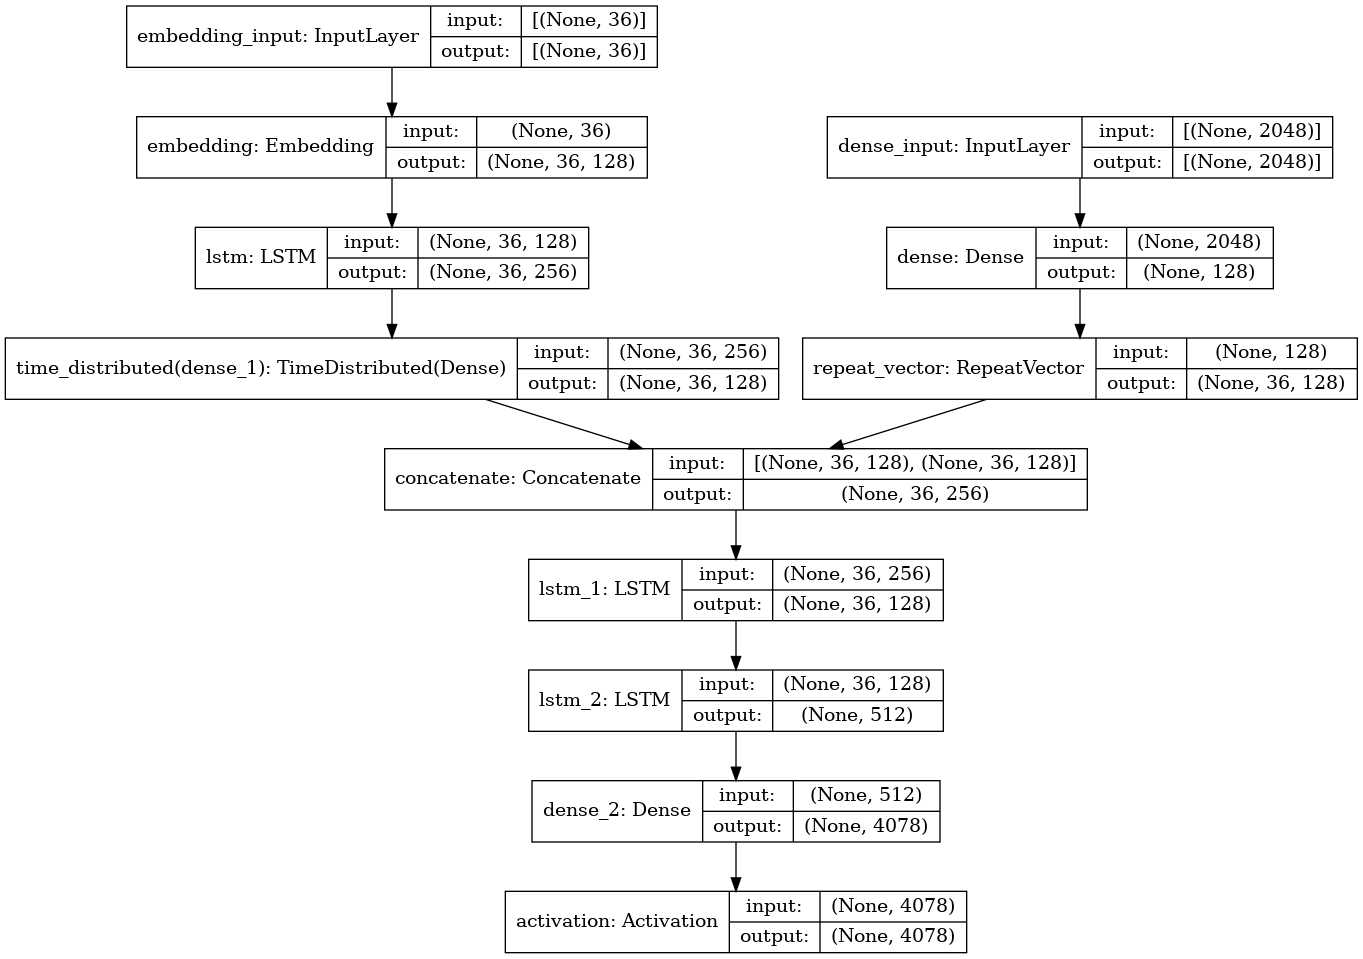

In [42]:
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True)

In [43]:
model.fit([X, y_in], y_out, batch_size=512, epochs=20)

2023-01-14 17:07:39.919917: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1575380336 exceeds 10% of free system memory.
2023-01-14 17:07:42.396736: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1575380336 exceeds 10% of free system memory.


Epoch 1/20
189/189 [==============================] - 21s 82ms/step - loss: 5.2571 - accuracy: 0.1200
Epoch 2/20
189/189 [==============================] - 16s 83ms/step - loss: 4.8419 - accuracy: 0.1656
Epoch 3/20
189/189 [==============================] - 16s 86ms/step - loss: 4.5055 - accuracy: 0.2310
Epoch 4/20
189/189 [==============================] - 17s 88ms/step - loss: 4.3085 - accuracy: 0.2567
Epoch 5/20
189/189 [==============================] - 16s 85ms/step - loss: 4.1871 - accuracy: 0.2660
Epoch 6/20
189/189 [==============================] - 16s 84ms/step - loss: 4.0601 - accuracy: 0.2760
Epoch 7/20
189/189 [==============================] - 16s 84ms/step - loss: 3.8900 - accuracy: 0.2939
Epoch 8/20
189/189 [==============================] - 16s 85ms/step - loss: 3.6414 - accuracy: 0.3248
Epoch 9/20
189/189 [==============================] - 16s 86ms/step - loss: 3.4446 - accuracy: 0.3466
Epoch 10/20
189/189 [==============================] - 16s 85ms/step - loss: 3.307

In [45]:
inv_dict = {v:k for k, v in count_words.items()}

In [46]:
model.save('model.h5')

In [47]:
model.save_weights('mine_model_weights.h5')

In [49]:
np.save('vocab.npy', count_words)

In [50]:
def getImage(x):
    
    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

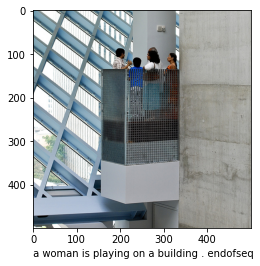

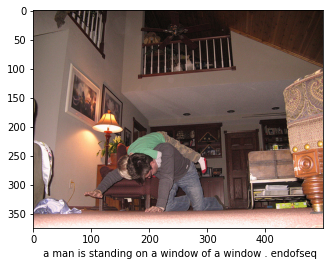

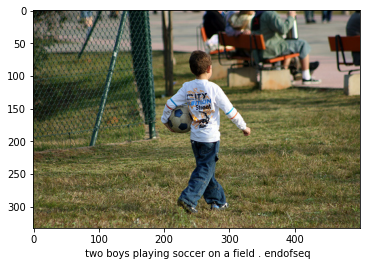

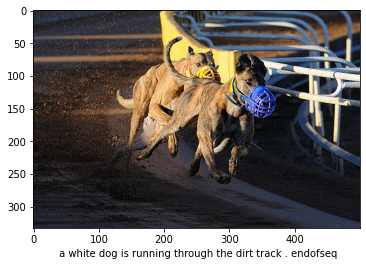

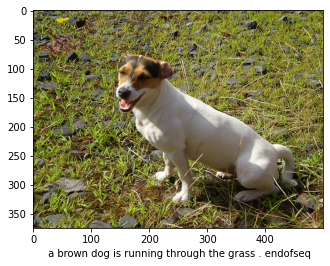

In [52]:
for i in range(5):
    
    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = modele.predict(getImage(no)).reshape(1,2048)
    
    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(count_words[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


        prediction = np.argmax(model.predict([test_feature, encoded]))

        sampled_word = inv_dict[prediction]

        caption = caption + ' ' + sampled_word
            
        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)
        
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)